## Vehicle Detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

---
## Histogram of Oriented Gradients (HOG)
### Data preparation

In [1]:
import glob
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import time
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.svm import LinearSVC
from scipy.ndimage.measurements import label
from collections import deque

### Images ###
# Read in our vehicles and non-vehicles
cars = glob.glob('./assets/vehicles/**/*.png', recursive=True)
notcars = glob.glob('./assets/non-vehicles/**/*.png', recursive=True)
#print(len(cars))
#print(len(notcars))

# Generate a random index to look at a car image
index = np.random.randint(0, len(cars))

# Read in the image
def gray(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Note: mpimg reads png as [0, 1] while cv2 reads it as [0, 255]
img_car = cv2.imread(cars[index])
img_notcar = cv2.imread(notcars[index])
img_car_gray = gray(img_car)
img_notcar_gray = gray(img_notcar)


### Visualization ###
def plt_subplots(n_row, n_col, imgs, cmaps=None, titles=None):
    for index, image in enumerate(imgs):
        cmap = cmaps[index] if cmaps != None else None
        title = titles[index] if titles != None else ''
        
        plt.subplot(n_row, n_col, index+1)    
        plt.imshow(image, cmap=cmaps[index])
        plt.title(titles[index])


In [2]:
# Tune parameters:

COLOR_SPACE = 'YCrCb'    # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
HOG_CHANNEL = 'ALL'      # Can be 0, 1, 2, or "ALL"

SPATIAL_SIZE = (8, 8)    # Color: spatial binning dimensions
HIST_BINS = 16           # Color: number of histogram bins

ORIENT = 9               # HOG orientations
PIX_PER_CELL = 8         # HOG pixels per cell
CELL_PER_BLOCK = 2       # HOG cells per block

FEATURE_SPATIAL = True   # Spatial features on or off
FEATURE_HISTOGRAM = True # Histogram features on or off
FEATURE_HOG = True       # HOG features on or off


### Color space, spatial binning of color, and histogram of color

In [3]:
### Color ###

# Color conversion
def convert_color(img, color_space='YCrCb'):
    if color_space == 'RGB':
        return np.copy(img)
    if color_space == 'HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if color_space == 'LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if color_space == 'HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if color_space == 'YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    if color_space == 'YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb) 

    
# Spatially binned color feature             
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features


# Color histograms feature
# - NEED TO CHANGE bins_range if reading .png files with mpimg!
# - TIP from Q/A video: skip bins_range as only nbins is useful to avoid issue with png VS jpeg
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)#, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)#, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)#, range=bins_range)
    # Concatenate the histograms into a single feature vector
    features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return features


### HOG features

Test index: 3562


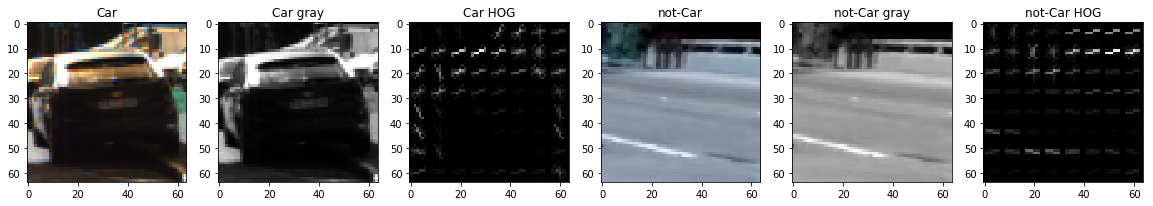

In [4]:
### HOG ###

# HOG features and visualization
# features: HOG for the image as a 1D (flattened) array
# img_hog: A visualisation of the HOG image
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Use skimage.hog() to get both features and the visualization
    if vis == True:
        features, img_hog = hog(
            img, orient, (pix_per_cell, pix_per_cell), (cell_per_block, cell_per_block), 
            visualise=vis, feature_vector=feature_vec
        )
        return features, img_hog  
    # Use skimage.hog() to get features only
    else:             
        features = hog(
            img, orient, (pix_per_cell, pix_per_cell), (cell_per_block, cell_per_block), 
            visualise=vis, feature_vector=feature_vec
        )
        return features

    
# Test one of examples
# PS. vis=True to see an image output
features_car, img_car_hog = get_hog_features(
    img_car_gray, ORIENT, PIX_PER_CELL, CELL_PER_BLOCK, 
    vis=True, feature_vec=False
)
features_notcar, img_notcar_hog = get_hog_features(
    img_notcar_gray, ORIENT, PIX_PER_CELL, CELL_PER_BLOCK, 
    vis=True, feature_vec=False
)

print("Test index:", index)
# data
plt_imgs = [img_car, img_car_gray, img_car_hog, img_notcar, img_notcar_gray, img_notcar_hog]
plt_cmap = [None, 'gray', 'gray', None, 'gray', 'gray']
plt_txts = ['Car', 'Car gray', 'Car HOG', 'not-Car', 'not-Car gray', 'not-Car HOG']
# draw
plt.figure(figsize=(20,5))
plt_subplots(1, 6, plt_imgs, plt_cmap, plt_txts)
plt.show()


### Feature extraction

In [5]:
# Extract features from a list of images
def extract_features(
    imgs, 
    color_space='RGB', 
    spatial_size=(32, 32),                      # spatial
    hist_bins=32,                               # histogram
    orient=9, pix_per_cell=8, cell_per_block=2, # HOG
    hog_channel=0,
    spatial_feat=True, 
    hist_feat=True, 
    hog_feat=True):
        
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        
        # Apply color conversion
        feature_image = convert_color(image, color_space=color_space)      
        
        # Compute spatial features
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
            
        # Compute histogram features    
        if hist_feat == True:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        
        # Compute HOG features
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(
                        feature_image[:,:,channel], 
                        orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True
                    ))
                hog_features = np.ravel(hog_features)        
            else:
                print(hog_channel)
                print(feature_image)
                hog_features = get_hog_features(
                    feature_image[:,:,hog_channel], 
                    orient, pix_per_cell, cell_per_block, 
                    vis=False, feature_vec=True
                )
            file_features.append(hog_features)
            
        features.append(np.concatenate(file_features))
        
    # Return list of feature vectors
    return features


t=time.time()
car_features = extract_features(
    cars, color_space=COLOR_SPACE, 
    spatial_size=SPATIAL_SIZE, hist_bins=HIST_BINS, 
    orient=ORIENT, pix_per_cell=PIX_PER_CELL, cell_per_block=CELL_PER_BLOCK, 
    hog_channel=HOG_CHANNEL, 
    spatial_feat=FEATURE_SPATIAL, 
    hist_feat=FEATURE_HISTOGRAM, 
    hog_feat=FEATURE_HOG
)

notcar_features = extract_features(
    notcars, color_space=COLOR_SPACE, 
    spatial_size=SPATIAL_SIZE, hist_bins=HIST_BINS, 
    orient=ORIENT, pix_per_cell=PIX_PER_CELL, cell_per_block=CELL_PER_BLOCK, 
    hog_channel=HOG_CHANNEL, 
    spatial_feat=FEATURE_SPATIAL, 
    hist_feat=FEATURE_HISTOGRAM, 
    hog_feat=FEATURE_HOG
)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')


79.37 Seconds to extract HOG features...


### Classifier

In [6]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64) 
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:', ORIENT, 'orientations', PIX_PER_CELL, 'pixels per cell and', CELL_PER_BLOCK, 'cells per block')
print('Feature vector length:', len(X_train[0]))

### Use a linear SVC
print('Linear SVC =>')
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts:  ', svc.predict(X_test[0:n_predict]))
print('For the',n_predict, 'labels:', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

### Use grid search
#parameters = {'kernel':('linear', 'rbf'), 'C':[0.1, 1, 10], 'gamma':[0.1, 1, 10]}
#svr = svm.SVC()
#clf = GridSearchCV(svr, parameters)
#clf.fit(X_train, y_train)
#print('Grid search =>')
#print('Best svm parameters:', clf.best_params_)
#print('Test Accuracy of SVC = ', round(clf.score(X_test, y_test), 4))
#print('My SVC predicts: ', clf.predict(X_test[0:n_predict]))
#print('For the',n_predict, 'labels:   ', y_test[0:n_predict])

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5532
Linear SVC =>
13.15 Seconds to train SVC...
Test Accuracy of SVC =  0.9913
My SVC predicts:   [ 0.  1.  0.  0.  1.  0.  0.  1.  0.  0.]
For the 10 labels: [ 0.  1.  0.  0.  1.  0.  0.  1.  0.  0.]
0.00217 Seconds to predict 10 labels with SVC


## Sliding Window Search
### Hog Sub-sampling

In [7]:
# Extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    img_cars = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, color_space='YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    box_list = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))       
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                box_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                cv2.rectangle(img_cars,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    #print(box_list)
    return img_cars, box_list

### Heatmap & False Positives

In [8]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap
    
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    
    # Return thresholded map
    return heatmap


def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    
    # Return the image
    return img


def filter_false_positive(img_test, box_list, threshold_heat):
    heat = np.zeros_like(img_test[:,:,0]).astype(np.float)
    
    # Add heat to each box in box list
    heat = add_heat(heat, box_list)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, threshold_heat)

    # Visualize the heatmap when displaying    
    vis_heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(vis_heatmap)
    img_label = draw_labeled_bboxes(np.copy(img_test), labels)
    
    return img_label, vis_heatmap


### Pipeline

In [9]:
# Tune parameters:

Y_START = 400
Y_STOP = 650
SCALE = 1.5

THRESHOLD_HEAT = 6  


Test: ./test_images/test4.jpg


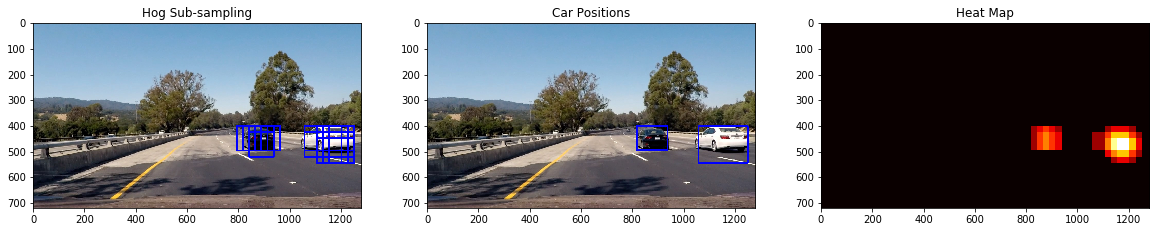

In [12]:
counter = 0
dq_boxes = deque()

def pipeline(image, threshold_heat):
    # Apply hog sub-sampling
    img_cars, box_list = find_cars(
        image, Y_START, Y_STOP, SCALE, 
        svc, X_scaler, ORIENT, PIX_PER_CELL, CELL_PER_BLOCK, 
        SPATIAL_SIZE, HIST_BINS
    )
    
    # Smooth detction: box list, deque
    global counter
    global dq_boxes
    
    if counter > 5:
        #print('count', counter, '(append and popleft)')
        dq_boxes.popleft()
        dq_boxes.append(box_list)
    else:
        #print('count', counter, '(append only)')
        dq_boxes.append(box_list)
        threshold_heat = counter + 3
    
    #print(counter, len(dq_boxes))
    counter = counter + 1
    for item in dq_boxes:
        box_list = box_list + item
    
    # Filter false positive
    img_label, vis_heatmap = filter_false_positive(
        image, box_list,
        threshold_heat
    )
    
    return [img_cars, img_label, vis_heatmap]


### Test
tests = glob.glob('./test_images/*.jpg', recursive=True)
index = np.random.randint(0, len(tests))
img_test = mpimg.imread(tests[index]) 


plt_imgs = pipeline(img_test, 1)
plt_cmap = [None, None, 'hot']
plt_txts = ['Hog Sub-sampling', 'Car Positions', 'Heat Map']

print("Test:", tests[index])
plt.figure(figsize=(20,5))
plt_subplots(1, 3, plt_imgs, plt_cmap, plt_txts)
plt.show()


## Video Implementation

In [13]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

import time
ts = str(int(time.time()))

def process_image(image):
    
    img_cars, img_label, vis_heatmap = pipeline(image, THRESHOLD_HEAT)#, dq_heatmaps)
    
    ### test
    #if counter == 8:
    #    plt_imgs = [img_cars, img_label, vis_heatmap]#pipeline(img_test)
    #    plt_cmap = [None, None, 'hot']
    #    plt_txts = ['Hog Sub-sampling', 'Car Positions', 'Heat Map']
    #    plt.figure(figsize=(20,5))
    #    plt_subplots(1, 3, plt_imgs, plt_cmap, plt_txts)
    #    plt.show()
    #    print(len(dq_boxes))
    #    plt_imgs = [dq_boxes[0], dq_boxes[1], dq_boxes[2]]
    #    plt_cmap = ['hot', 'hot', 'hot']
    #    plt_txts = ['Hog 0', 'Hot 1', 'Hot2']
    #    plt.figure(figsize=(20,5))
    #    plt_subplots(1, 3, plt_imgs, plt_cmap, plt_txts)
    #    plt.show()
    #    dst = img_cars*2 + dq_boxes[0] + dq_boxes[1] + dq_boxes[2]
    #    #dst = cv2.addWeighted(vis_heatmap,2,dq_heatmaps[0],1,dq_heatmaps[1],1,dq_heatmaps[2],1,0)
    #    plt.imshow(dst, cmap='hot')
    #    print(dst)
    ### end of test ###
    
    return img_label#pipeline(image)[1]

# process
#video_flname1 = 'test_video.mp4'
video_flname1 = 'project_video.mp4'
video_output1 = 'output_videos/' + ts + '_' + video_flname1 + '_output.mp4'
clip1 = VideoFileClip(video_flname1)
video_clip1 = clip1.fl_image(process_image)
%time video_clip1.write_videofile(video_output1, audio=False)
    
# display
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format(video_output1))


[MoviePy] >>>> Building video output_videos/1506406824_project_video.mp4_output.mp4
[MoviePy] Writing video output_videos/1506406824_project_video.mp4_output.mp4


100%|█████████▉| 1260/1261 [05:54<00:00,  3.57it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/1506406824_project_video.mp4_output.mp4 

CPU times: user 5min 47s, sys: 10.8 s, total: 5min 57s
Wall time: 5min 54s
